<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2Ftwomoons/notebooks/smoothNF_VS_affineNF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nomalizing Flow with implicit coupling layers


In [ ]:
!pip install --quiet --upgrade dm-haiku optax 
!pip install git+https://github.com/Justinezgh/SBI-Diff-Simulator.git

In [2]:
import logging
# Removing annoying TFP error message
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [3]:
%pylab inline
import jax
import jax.numpy as jnp
import haiku as hk
import optax
from tqdm import tqdm
from functools import partial
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Populating the interactive namespace from numpy and matplotlib


In [4]:
from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP, AffineCoupling
from sbids.tasks.two_moons import get_two_moons

### Affine coupling layer VS smooth coupling layer (trained with score matching)

In [6]:
d=2
batch_size = 128
it = 3000

In [7]:
@jax.jit
def get_batch(seed):
  two_moons = get_two_moons(sigma = 0.01, normalized=True)
  batch = two_moons.sample(batch_size, seed=seed)
  score = jax.vmap(jax.grad(two_moons.log_prob))(batch)
  return batch, score

In [8]:
import arviz as az
az.style.use("arviz-darkgrid")

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4457: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:1806: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")


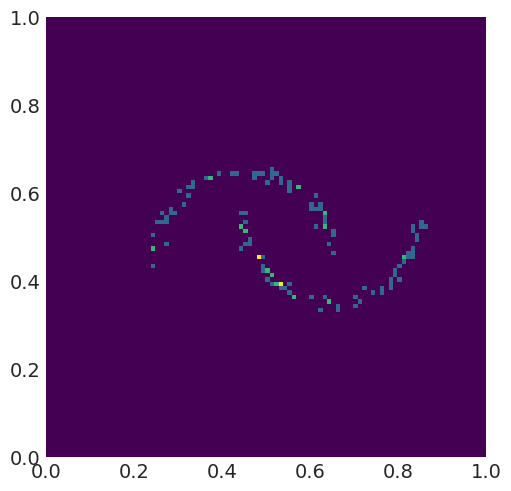

In [9]:
batch, score = get_batch(jax.random.PRNGKey(0))
hist2d(batch[:,0], batch[:,1],100, range=[[0,1],[0,1]]); gca().set_aspect('equal');

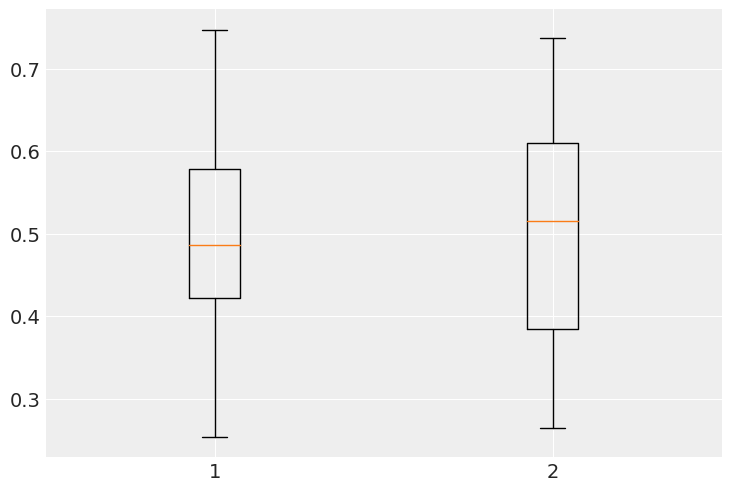

In [10]:
transformation_params = tfb.Chain([tfb.Scale([0.8,1.5]),tfb.Shift([0.07,-0.16])])
normalized = transformation_params.forward(batch)
plt.boxplot([normalized[:,0], normalized[:,1]]);

In [12]:
bijector_affine = partial(AffineCoupling,layers = [256,256,256])
bijector_smooth = partial(AffineSigmoidCoupling, 
                   layers = [256,256,256],
                   n_components = 16, 
                   activation = jnp.sin)

NF_affine = partial(ConditionalRealNVP, n_layers = 4, bijector_fn = bijector_affine)
NF_smooth = partial(ConditionalRealNVP, n_layers = 4, bijector_fn = bijector_smooth)

model_affine = hk.without_apply_rng(hk.transform(
    lambda p:tfd.TransformedDistribution(NF_affine(2)(jnp.ones([1,1])), 
                                           tfb.Invert(transformation_params)).log_prob(p)))
model_smooth = hk.without_apply_rng(hk.transform(
    lambda p:tfd.TransformedDistribution(NF_smooth(2)(jnp.ones([1,1])), 
                                           tfb.Invert(transformation_params)).log_prob(p)))

In [13]:
rng_seq = hk.PRNGSequence(12)
params_affine = model_affine.init(next(rng_seq), p=jnp.zeros([1,2]))

rng_seq = hk.PRNGSequence(12)
params_smooth = model_smooth.init(next(rng_seq), p=jnp.zeros([1,2]))

In [14]:
def loss_affine(params, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda x, param: model_affine.apply(param, x.reshape([1,2])).squeeze()), [0, None])(batch, params) 
  return  jnp.mean( jnp.sum((out - score)**2, axis=1))/1000  


def loss_smooth(params, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda x, param: model_smooth.apply(param, x.reshape([1,2])).squeeze()), [0, None])(batch, params) 
  return  jnp.mean( jnp.sum((out - score)**2, axis=1))/1000  

In [15]:
learning_rate=0.0001

optimizer_affine = optax.adam(learning_rate)
opt_state_affine = optimizer_affine.init(params_affine)


optimizer_smooth = optax.adam(learning_rate)
opt_state_smooth = optimizer_smooth.init(params_smooth)

In [16]:
@jax.jit
def update_affine(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_affine)(params, batch, score)
    updates, new_opt_state = optimizer_affine.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state


@jax.jit
def update_smooth(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_smooth)(params, batch, score)
    updates, new_opt_state = optimizer_smooth.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [17]:
losses = []
master_seed = hk.PRNGSequence(0)

In [18]:
for step in tqdm(range(it)):
    batch, score = get_batch(next(master_seed))
    l, params_affine, opt_state_affine = update_affine(params_affine, opt_state_affine, batch, score)
    losses.append(l)
    if jnp.isnan(l):
      break

100%|██████████| 3000/3000 [00:16<00:00, 182.18it/s]


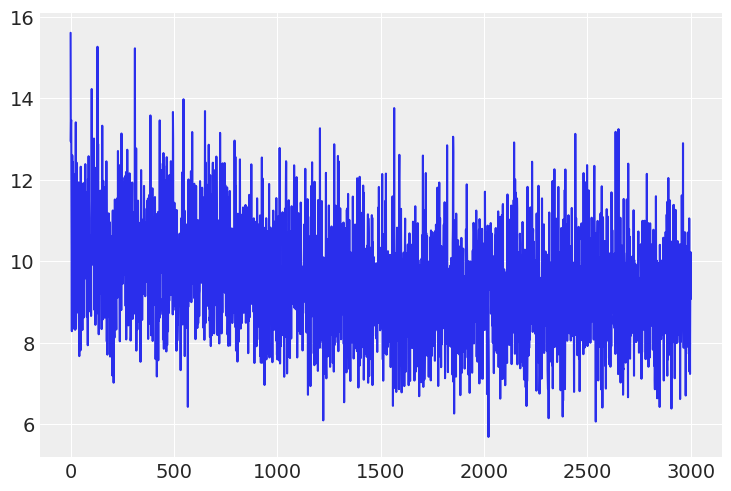

In [19]:
plt.plot(losses)

In [20]:
losses[-1]

DeviceArray(9.068055, dtype=float32)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4457: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:1806: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")


<Figure size 720x480 with 0 Axes>

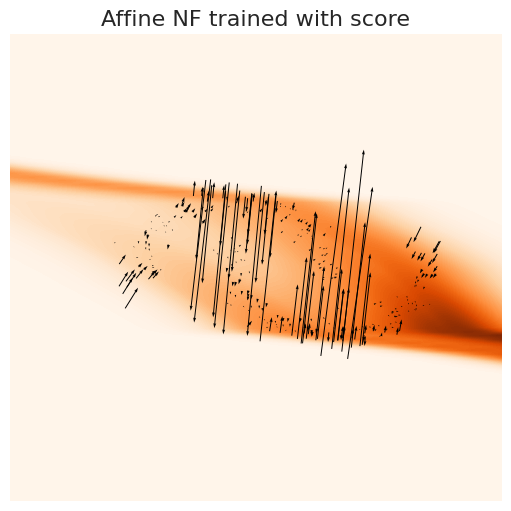

In [21]:
# predicted two moons distribution
plt.clf()
x = jnp.stack(jnp.meshgrid(jnp.linspace(0.,1.,128),
                           jnp.linspace(0.,1.,128)),-1)

im0 = jax.vmap((lambda x: model_affine.apply(params_affine, x.reshape([1,2])).squeeze()))(x.reshape([-1,2])).reshape([128,128])

two_moons = get_two_moons(sigma = 0.02, normalized=True)
batch=two_moons.sample(300, seed=next(master_seed))
pred_score = jax.vmap(jax.grad(lambda x: model_affine.apply(params_affine, x.reshape([1,2])).squeeze()))(batch)


plt.figure(figsize=(5,5),dpi=100)
plt.contourf(x[...,0],x[...,1],jnp.exp(im0), 100,cmap='Oranges')
quiver(batch.T[0], batch.T[1], pred_score[:,0] ,pred_score[:,1],width=0.002);
plt.axis('off')
plt.title('Affine NF trained with score')
plt.savefig('affineNF.png', transparent=True, bbox_inches='tight',
        pad_inches = 0)

In [22]:
losses_smooth = []
master_seed = hk.PRNGSequence(0)

In [23]:
for step in tqdm(range(it)):
    batch, score = get_batch(next(master_seed))
    l, params_smooth, opt_state_smooth = update_smooth(params_smooth, opt_state_smooth, batch, score)
    losses_smooth.append(l)

100%|██████████| 3000/3000 [01:58<00:00, 25.41it/s]


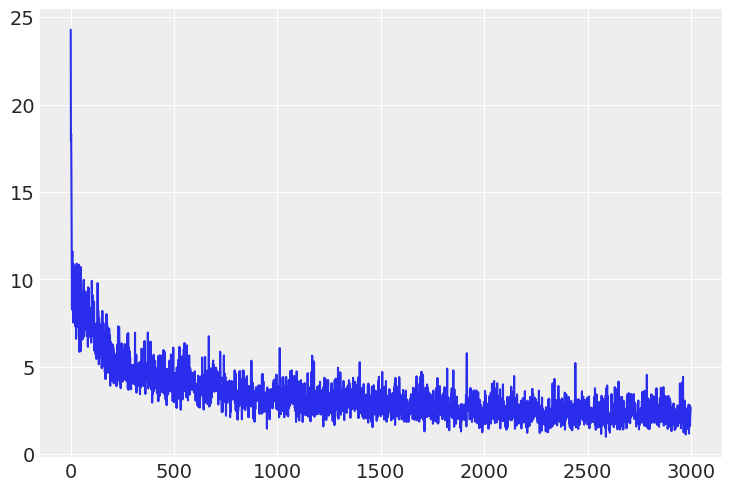

In [24]:
plot(losses_smooth)

In [25]:
losses_smooth[-1]

DeviceArray(2.6832418, dtype=float32)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4457: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:1806: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")


<Figure size 720x480 with 0 Axes>

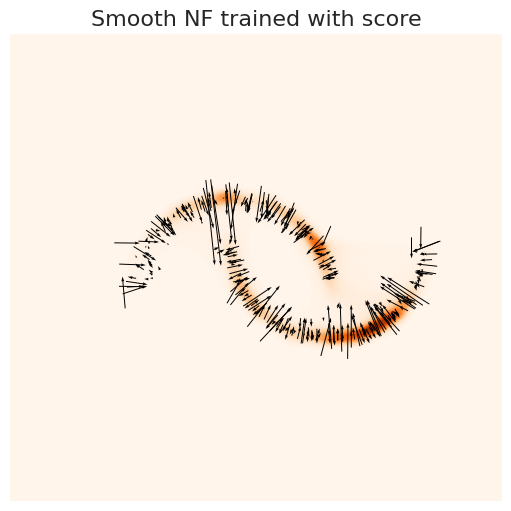

In [26]:
# predicted two moons distribution
plt.clf()
x = jnp.stack(jnp.meshgrid(jnp.linspace(0.,1.,128),
                           jnp.linspace(0.,1.,128)),-1)

im0 = jax.vmap((lambda x: model_smooth.apply(params_smooth, x.reshape([1,2])).squeeze()))(x.reshape([-1,2])).reshape([128,128])

two_moons = get_two_moons(sigma = 0.02, normalized=True)
batch=two_moons.sample(300, seed=next(master_seed))
pred_score = jax.vmap(jax.grad(lambda x: model_smooth.apply(params_smooth, x.reshape([1,2])).squeeze()))(batch)


plt.figure(figsize=(5,5),dpi=100)
plt.contourf(x[...,0],x[...,1],jnp.exp(im0), 100,cmap='Oranges')
quiver(batch.T[0], batch.T[1], pred_score[:,0] ,pred_score[:,1],width=0.002);
plt.axis('off')
plt.title('Smooth NF trained with score')
plt.savefig('smoothNF.png', transparent=True, bbox_inches='tight',
        pad_inches = 0)